## LST Sensitivity calculation using pyirf

This notebook allow to calculate the best LST sensitivity using real data.
It uses MC gammas to optimize the best gammaness and $\theta^2$ cuts.
The gammaness cut can be optimized based on gamma efficiency or on the best sensitivity.
Cuts are then applied to ON/OFF data to calculate sensitivity.
Sensitivity using MC gammas as signal is also calculated.
Some useful plots such as rates, cuts per energy bin, angular resolution, etc. are shown at the end. 


### Needed imports

In [1]:
from lstchain.io.io import read_dl2_to_pyirf, dl2_params_lstcam_key
import logging
import operator
from lstchain.mc import plot_utils

import numpy as np
from astropy import table
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import QTable
import pandas as pd

from pyirf.io.eventdisplay import read_eventdisplay_fits
from pyirf.binning import (
    create_bins_per_decade,
    add_overflow_bins,
    create_histogram_table,
)
from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.sensitivity import calculate_sensitivity
from pyirf.utils import calculate_theta, calculate_source_fov_offset
from pyirf.benchmarks import energy_bias_resolution, angular_resolution

from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.sensitivity import calculate_sensitivity, estimate_background
from pyirf.utils import calculate_theta, calculate_source_fov_offset
from pyirf.benchmarks import energy_bias_resolution, angular_resolution

from pyirf.spectral import (
    calculate_event_weights,
    PowerLaw,
    CRAB_HEGRA
)
from pyirf.cut_optimization import optimize_gh_cut

from pyirf.irf import (
    effective_area_per_energy,
    energy_dispersion,
    psf_table,
    background_2d,
)

from pyirf.io import (
    create_aeff2d_hdu,
    create_psf_table_hdu,
    create_energy_dispersion_hdu,
    create_rad_max_hdu,
    create_background_2d_hdu,
)

log = logging.getLogger("pyirf")

/home/queenmab/anaconda3/envs/lst-dev/lib/python3.7/site-packages/ctapipe/tools/stage1.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Initial variables

In [2]:
#Observation time for sensitivity
T_OBS = 50 * u.hour
# scaling between on and off region.
# Make off region 5 times larger than on region for better
# background statistics
ALPHA = 1/5

# Radius to use for calculating bg rate
MAX_BG_RADIUS = 1.0 * u.deg

# gamma efficiency used for first calculation of the binned theta cuts
INITIAL_GH_CUT_EFFICENCY = 0.4

#gamma efficiency used for gh cuts calculation
GH_CUT_EFFICIENCY = 0.8

#Number of energy bins
N_EBINS = 20

In [3]:
def get_obstime_real(events):
    """Calculate the effective observation time"""
    tib_time = events.tib_time.to_numpy()
    last_event = events.shape[0]-1
    total_time = tib_time[last_event]-tib_time[0]
    deltat = np.ndarray(tib_time.size)
    for i in range(tib_time.size-1):
        deltat_event = tib_time[i+1]-tib_time[i]
        deltat[i]=deltat_event

    deltat = deltat[(deltat > 0) & (deltat < 0.002)]
    hist, bins = np.histogram(deltat, bins=100)
    dead_time = bins[0]
    t_elapsed =(sum(deltat) - dead_time) * u.s
    bin_center=np.sqrt(bins[1:] * bins[:-1])
    fit_result = np.polyfit(bin_center, np.log10(hist), 1)
    rate=-1*fit_result[0]
    total_dead_time=rate*dead_time
    t_eff = t_elapsed/(1+total_dead_time)


    print("ELAPSED TIME: %.2f s\n" % t_elapsed.to_value(),
          "EFFECTIVE TIME: %.2f s\n" % t_eff.to_value(),
          "DEAD TIME: %f s\n" % dead_time,
          "RATE: %.2f 1/s\n" % rate
    )

    return t_eff

In [4]:
def read_real_dl2_to_pyirf(filename):
    """
    Read DL2 files of real data from lstchain and convert into pyirf internal format
    Parameters
    ----------
    filename: path
    Returns
    -------
    `astropy.table.QTable`, `pyirf.simulations.SimulatedEventsInfo`
    """

    ## mapping
    name_mapping = {
        'alt_tel': 'pointing_alt',
        'az_tel': 'pointing_az',
        'gammaness': 'gh_score',
    }

    unit_mapping = {
        'reco_energy': u.TeV,
        'pointing_alt': u.rad,
        'pointing_az': u.rad,
        'reco_alt': u.rad,
        'reco_az': u.rad,
    }

    events = pd.read_hdf(filename, key=dl2_params_lstcam_key).rename(columns=name_mapping)
    
    obstime_real = get_obstime_real(events) #Calculate effective observation time
    
    filter_good_events = (
        (events.leakage_intensity_width_2 < 0.2)
        & (events.intensity > 100)
    )
    events = events[filter_good_events]
    events = table.QTable.from_pandas(events)

    for k, v in unit_mapping.items():
        events[k] *= v

    return events, obstime_real

### Read hdf5 files into pyirf format

In [5]:
file_gammas = "/home/queenmab/DATA/LST/dl2_gamma_20deg_180deg_off0.0deg_20201023_v0.6.3_prod5_local_wo_n_islands_testing.h5"
file_on = "/home/queenmab/DATA/LST/Run2008_on.h5"
file_protons = "/home/queenmab/DATA/LST/OFF.h5"

In [6]:
events_g, simu_info_g = read_dl2_to_pyirf(file_gammas)
events_p, obstime_protons = read_real_dl2_to_pyirf(file_protons)
events_on, obstime_on = read_real_dl2_to_pyirf(file_on)

Table '/simulation/run_config' has column 'obs_id' that is not in container MCHeaderContainer. It will be skipped


ELAPSED TIME: 1290.69 s
 EFFECTIVE TIME: 1263.19 s
 DEAD TIME: 0.000008 s
 RATE: 2853.34 1/s

ELAPSED TIME: 1211.56 s
 EFFECTIVE TIME: 1211.56 s
 DEAD TIME: 0.000000 s
 RATE: 1976.79 1/s



In [7]:
particles = {
         "gamma": {
                "events": events_g,
                "simulation_info": simu_info_g,
                "target_spectrum": CRAB_HEGRA,
            },
        "proton": {
                "events": events_p,
            },
        "on":{
                "events": events_on
            }
        }

In [8]:
# Manage MC gammas:
#Get simulated spectrum
particles["gamma"]["simulated_spectrum"] = PowerLaw.from_simulation(particles["gamma"]["simulation_info"], 
                                                                    T_OBS)
#Reweight to target spectrum (Crab Hegra)
particles["gamma"]["events"]["weight"] = calculate_event_weights(
        particles["gamma"]["events"]["true_energy"], 
        particles["gamma"]["target_spectrum"], 
        particles["gamma"]["simulated_spectrum"]
        )

particles["gamma"]["events"]["source_fov_offset"] = calculate_source_fov_offset(particles["gamma"]["events"])
# calculate theta / distance between reco and assuemd source positoin
# we handle only ON observations here, so the assumed source pos
# is the pointing position
particles["gamma"]["events"]["theta"] = calculate_theta(
        particles["gamma"]["events"],
        assumed_source_az=particles["gamma"]["events"]["true_az"],
        assumed_source_alt=particles["gamma"]["events"]["true_alt"],
        )

In [9]:
#Manage real data: Protons

#Weight by the actual observation time
particles["proton"]["events"]["weight"] = T_OBS.to(u.s)/obstime_protons

#True az and true alt are unknown for real data, pointing is used instead
particles["proton"]["events"]["true_az"] = particles["proton"]["events"]["pointing_az"]
particles["proton"]["events"]["true_alt"] = particles["proton"]["events"]["pointing_alt"]

particles["proton"]["events"]["source_fov_offset"] = calculate_source_fov_offset(particles["proton"]["events"])
# calculate theta / distance between reco and assuemd source positoin
# we handle only ON observations here, so the assumed source pos
# is the pointing position
particles["proton"]["events"]["theta"] = calculate_theta(
        particles["proton"]["events"],
        assumed_source_az=particles["proton"]["events"]["pointing_az"],
        assumed_source_alt=particles["proton"]["events"]["pointing_alt"],
    )


In [10]:
#Manage real data: ON  

#Weight by the actual observation time
particles["on"]["events"]["weight"] = T_OBS.to(u.s)/obstime_on

#True az and true alt are unknown for real data, pointing is used instead
particles["on"]["events"]["true_az"] = particles["on"]["events"]["pointing_az"]
particles["on"]["events"]["true_alt"] = particles["on"]["events"]["pointing_alt"]

particles["on"]["events"]["source_fov_offset"] = calculate_source_fov_offset(particles["on"]["events"])

particles["on"]["events"]["theta"] = calculate_theta(
        particles["on"]["events"],
        assumed_source_az=particles["on"]["events"]["pointing_az"],
        assumed_source_alt=particles["on"]["events"]["pointing_alt"],
    )

In [11]:
#Get events
gammas = particles["gamma"]["events"]
on = particles["on"]["events"]
background = particles["proton"]["events"]

## Calculate the best cuts for sensitivity

In [12]:
INITIAL_GH_CUT = np.quantile(gammas['gh_score'], (1 - INITIAL_GH_CUT_EFFICENCY))
log.info(f"Using fixed G/H cut of {INITIAL_GH_CUT} to calculate theta cuts")
INITIAL_GH_CUT

0.3425

### Define bins

In [13]:
#Sensitivity energy bins
sensitivity_bins = np.logspace(np.log10(0.005),
    np.log10(50), N_EBINS + 1) * u.TeV

### Initial $\theta$ cut

In [14]:
# theta cut is 68 percent containmente of the gammas
# for now with a fixed global, unoptimized score cut
mask_theta_cuts = gammas["gh_score"] >= INITIAL_GH_CUT
theta_cuts = calculate_percentile_cut(
        gammas["theta"][mask_theta_cuts],
        gammas["reco_energy"][mask_theta_cuts],
        bins=sensitivity_bins,
        min_value=0.05 * u.deg,
        fill_value=np.nan * u.deg,
        percentile=68,
)
# evaluate the theta cut
gammas["selected_theta"] = evaluate_binned_cut(
    gammas["theta"], gammas["reco_energy"], theta_cuts, operator.le
    )

### Run block below for G/H cut optimization based on best sensitivity

In [16]:
log.info("Optimizing G/H separation cut for best sensitivity")
sensitivity_step_2, gh_cuts = optimize_gh_cut(
    gammas[gammas["selected_theta"]],
    background,
    reco_energy_bins=sensitivity_bins,
    gh_cut_values=np.arange(-1.0, 1.005, 0.05),
    theta_cuts=theta_cuts,
    op=operator.ge,
    alpha=ALPHA,
    background_radius=MAX_BG_RADIUS,
)

 73%|███████▎  | 30/41 [00:53<00:13,  1.27s/it]/home/queenmab/anaconda3/envs/lst-dev/lib/python3.7/site-packages/pyirf/sensitivity.py:176: RuntimeWarning: invalid value encountered in multiply
  s["n_signal"] = signal_hist["n"] * rel_sens
/home/queenmab/anaconda3/envs/lst-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 41/41 [00:58<00:00,  1.42s/it]


### Run block below for G/H cut based on gamma efficiency

In [15]:
gh_cuts = calculate_percentile_cut(
           gammas["gh_score"],
            gammas["reco_energy"],
            bins=sensitivity_bins,
            min_value=0.0,
            fill_value=1.0,
            percentile=(1-GH_CUT_EFFICIENCY)*100
)

In [16]:
#Evaluate gh cut
for tab in (gammas, background, on):
    tab["selected_gh"] = evaluate_binned_cut(
    tab["gh_score"], tab["reco_energy"], gh_cuts, operator.ge
    )

### Optimization of $\theta$ cut as 68% containment of events surviving the cuts

In [17]:
#Evaluate gh cut:
for tab in (gammas, background, on):
    tab["selected_gh"] = evaluate_binned_cut(
    tab["gh_score"], tab["reco_energy"], gh_cuts, operator.ge
    )

theta_cuts_opt = calculate_percentile_cut(
    gammas[gammas["selected_gh"]]["theta"],
    gammas[gammas["selected_gh"]]["reco_energy"],
    sensitivity_bins,
    percentile=68,
    fill_value=0.32 * u.deg,
    max_value=0.32 * u.deg,
    min_value=0.05 * u.deg,
    )

In [18]:
#Theta cut for background: Enlarge background cut for better statistics
theta_cuts_bkg = theta_cuts_opt.copy()
for i in range(0, len(theta_cuts_opt["cut"])):
    theta_cuts_bkg["cut"][i]=MAX_BG_RADIUS

### Evaluate optimized cuts

In [19]:
gammas["selected_theta"] = evaluate_binned_cut(
        gammas["theta"], gammas["reco_energy"], theta_cuts_opt, operator.le
    )
gammas["selected"] = gammas["selected_theta"] & gammas["selected_gh"]

on["selected_theta"] = evaluate_binned_cut(
        on["theta"], on["reco_energy"], theta_cuts_opt, operator.le
    )
on["selected"] = on["selected_theta"] & on["selected_gh"]

background["selected_theta"] = evaluate_binned_cut(
        background["theta"], background["reco_energy"], theta_cuts_bkg, operator.le
    )
background["selected"] = background["selected_theta"] & background["selected_gh"]

### Crate event histograms

In [20]:
signal_hist = create_histogram_table(
    gammas[gammas["selected"]], bins=sensitivity_bins
    )    
on_hist = create_histogram_table(
    on[on["selected"]], bins=sensitivity_bins
    )
background_hist = estimate_background(
    background[background["selected"]],
    reco_energy_bins=sensitivity_bins,
    theta_cuts=theta_cuts_opt,
    alpha=ALPHA,
    background_radius=MAX_BG_RADIUS,
    )

### Sensitivity with MC gammas

In [21]:
sensitivity = calculate_sensitivity(
    signal_hist, background_hist, alpha=ALPHA
)
sensitivity

/home/queenmab/anaconda3/envs/lst-dev/lib/python3.7/site-packages/pyirf/sensitivity.py:176: RuntimeWarning: invalid value encountered in multiply
  s["n_signal"] = signal_hist["n"] * rel_sens
/home/queenmab/anaconda3/envs/lst-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_background,n_signal_weighted,n_background_weighted,failed_checks,relative_sensitivity
TeV,TeV,TeV,,,,,,
float64,float64,float64,float64,float64,float64,float64,int64,float64
0.004999999999999999,0.007924465962305569,0.006462232981152784,nan,0.0,nan,0.0,4,nan
0.007924465962305569,0.012559432157547895,0.010241949059926732,1.3465564980300893,0.0,6.9763828318905885,0.0,1,nan
0.012559432157547895,0.019905358527674864,0.01623239534261138,41.710113236304515,51.20116662803144,215.04005888999603,7295.972384833071,0,0.006369901227291466
0.019905358527674864,0.03154786722400966,0.025726612875842263,702.2673129613538,11933.967917661568,3200.0879377143415,1700545.243456966,2,nan
0.03154786722400966,0.049999999999999996,0.04077393361200483,2195.8956538718207,73924.75638921806,7955.926309235226,10533997.888948463,2,nan
0.049999999999999996,0.0792446596230557,0.06462232981152785,3186.0677299547046,76448.97390398002,8090.518049398532,10893689.327527545,2,nan
0.0792446596230557,0.12559432157547903,0.10241949059926736,2793.3080179813296,28846.73727823291,4972.048798945465,4110550.8416088633,2,nan
0.12559432157547903,0.19905358527674863,0.16232395342611383,1551.681201519214,4748.57332240403,2020.7560013125378,676653.7192230856,2,nan


### Sensitivity with ON data

In [22]:
#Signal = ON - ALPHA*OFF
on_hist["n_weighted"] = on_hist["n_weighted"] - ALPHA*background_hist["n_weighted"]

sensitivity_on = calculate_sensitivity(
    on_hist, background_hist, alpha=ALPHA
    )
sensitivity_on

reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_background,n_signal_weighted,n_background_weighted,failed_checks,relative_sensitivity
TeV,TeV,TeV,,,,,,
float64,float64,float64,float64,float64,float64,float64,int64,float64
0.004999999999999999,0.007924465962305569,0.006462232981152784,nan,0.0,nan,0.0,4,nan
0.007924465962305569,0.012559432157547895,0.010241949059926732,nan,0.0,nan,0.0,4,nan
0.012559432157547895,0.019905358527674864,0.01623239534261138,13.512331764477787,51.20116662803144,215.0400588899961,7295.972384833071,4,nan
0.019905358527674864,0.03154786722400966,0.025726612875842263,207.7818401514146,11933.967917661568,3200.087937714343,1700545.243456966,2,nan
0.03154786722400966,0.049999999999999996,0.04077393361200483,382.81122670133334,73924.75638921806,7955.926309056225,10533997.888948463,2,nan
0.049999999999999996,0.0792446596230557,0.06462232981152785,312.22528925495834,76448.97390398002,8090.518049055608,10893689.327527545,2,nan
0.0792446596230557,0.12559432157547903,0.10241949059926736,205.66155323213368,28846.73727823291,4972.048798945467,4110550.8416088633,2,nan
0.12559432157547903,0.19905358527674863,0.16232395342611383,38.932881090965566,4748.57332240403,2020.7560013125378,676653.7192230856,2,nan


In [23]:
# scale relative sensitivity by Crab flux to get the flux sensitivity
spectrum = particles['gamma']['target_spectrum']
for s in (sensitivity, sensitivity_on):
    s["flux_sensitivity"] = (
        s["relative_sensitivity"] * spectrum(s["reco_energy_center"])
     )

### Write outputs

In [24]:
# write output file
hdus = [
    fits.PrimaryHDU(),
    fits.BinTableHDU(sensitivity, name="SENSITIVITY"),
    fits.BinTableHDU(sensitivity_on, name="SENSITIVITY_ON"),
    fits.BinTableHDU(theta_cuts, name="THETA_CUTS"),
    fits.BinTableHDU(theta_cuts_opt, name="THETA_CUTS_OPT"),
    fits.BinTableHDU(gh_cuts, name="GH_CUTS")
        ]

masks = {
    "": gammas["selected"],
    "_NO_CUTS": slice(None),
    "_ONLY_GH": gammas["selected_gh"],
    "_ONLY_THETA": gammas["selected_theta"],
        }

# binnings for the irfs
true_energy_bins = add_overflow_bins(
    create_bins_per_decade(10 ** -1.9 * u.TeV, 10 ** 2.31 * u.TeV, 10,)
        )
reco_energy_bins = add_overflow_bins(
    create_bins_per_decade(10 ** -1.9 * u.TeV, 10 ** 2.31 * u.TeV, 5)
        )
fov_offset_bins = [0, 0.5] * u.deg
source_offset_bins = np.arange(0, 1 + 1e-4, 1e-3) * u.deg
energy_migration_bins = np.geomspace(0.2, 5, 200)

for label, mask in masks.items():
    effective_area = effective_area_per_energy(
            gammas[mask],
            particles["gamma"]["simulation_info"],
            true_energy_bins=true_energy_bins,
                )
    hdus.append(
            create_aeff2d_hdu(
                effective_area[..., np.newaxis],  # add one dimension for FOV offset
                true_energy_bins,
                fov_offset_bins,
                extname="EFFECTIVE_AREA" + label,
                )
            )
    edisp = energy_dispersion(
                gammas[mask],
                true_energy_bins=true_energy_bins,
                fov_offset_bins=fov_offset_bins,
                migration_bins=energy_migration_bins,
            )
    hdus.append(
            create_energy_dispersion_hdu(
            edisp,
            true_energy_bins=true_energy_bins,
            migration_bins=energy_migration_bins,
            fov_offset_bins=fov_offset_bins,
            extname="ENERGY_DISPERSION" + label,
                )
            )

bias_resolution = energy_bias_resolution(
    gammas[gammas["selected"]], true_energy_bins,
        )
ang_res = angular_resolution(gammas[gammas["selected_gh"]], true_energy_bins,)
on["true_energy"] = on["reco_energy"]
ang_res_real = angular_resolution(on[on["selected_gh"]], true_energy_bins,)

psf = psf_table(
    gammas[gammas["selected_gh"]],
    true_energy_bins,
    fov_offset_bins=fov_offset_bins,
    source_offset_bins=source_offset_bins,
    )

psf_on = psf_table(
    on[on["selected_gh"]],
    true_energy_bins,
    fov_offset_bins=fov_offset_bins,
    source_offset_bins=source_offset_bins,
    )

hdus.append(
    create_psf_table_hdu(
    psf, true_energy_bins, source_offset_bins, fov_offset_bins,
        )
    )
hdus.append(
    create_psf_table_hdu(
    psf_on, true_energy_bins, source_offset_bins, fov_offset_bins,
    extname="PSF_ON"
        )
    )

hdus.append(create_rad_max_hdu(
    theta_cuts_opt["cut"][:, np.newaxis], sensitivity_bins, fov_offset_bins
        )
    )
hdus.append(fits.BinTableHDU(ang_res, name="ANGULAR_RESOLUTION"))
hdus.append(fits.BinTableHDU(ang_res_real, name="ANGULAR_RESOLUTION_ON"))
hdus.append(fits.BinTableHDU(bias_resolution, name="ENERGY_BIAS_RESOLUTION"))
fits.HDUList(hdus).writeto("pyirf_sensitivity.fits.gz", overwrite=True)

/home/queenmab/anaconda3/envs/lst-dev/lib/python3.7/site-packages/pyirf/simulations.py:186: RuntimeWarning: divide by zero encountered in reciprocal
  e_term = e_high ** int_index - e_low ** int_index
/home/queenmab/anaconda3/envs/lst-dev/lib/python3.7/site-packages/pyirf/irf/effective_area.py:27: RuntimeWarning: invalid value encountered in true_divide
  return (n_selected / n_simulated) * area


### Plot Sensitivity curves

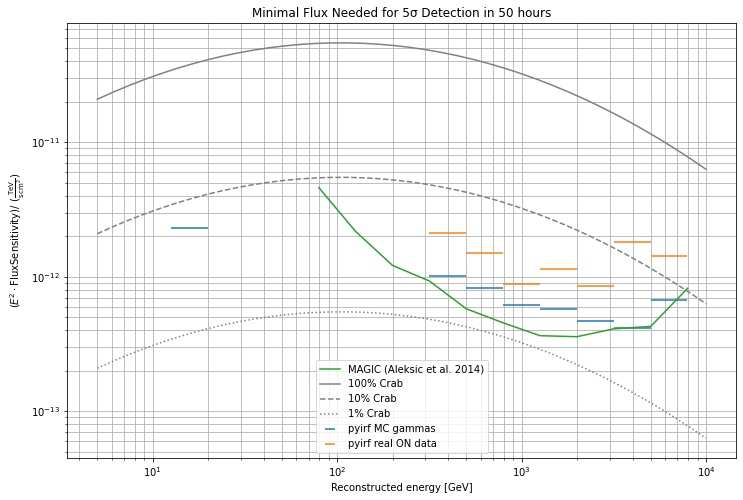

In [25]:
plt.figure(figsize=(12,8))
ax=plt.axes()
unit = u.Unit('TeV cm-2 s-1')

#Results from pyirf

e = sensitivity['reco_energy_center']

s = (e**2 * sensitivity['flux_sensitivity'])

plt.errorbar(
    e.to_value(u.GeV),
    s.to_value(unit),
    xerr=(sensitivity['reco_energy_high'] - sensitivity['reco_energy_low']).to_value(u.GeV) / 2,
    ls='',
    label='pyirf MC gammas',
    )

s_on = (e**2 * sensitivity_on['flux_sensitivity'])

plt.errorbar(
    e.to_value(u.GeV),
    s_on.to_value(unit),
    xerr=(sensitivity_on['reco_energy_high'] - sensitivity_on['reco_energy_low']).to_value(u.GeV) / 2,
    ls='',
    label='pyirf real ON data',
    )

#Plot magic sensitivity
s = np.loadtxt('../lstchain/spectra/data/magic_sensitivity.txt', skiprows = 1)
ax.loglog(s[:,0], s[:,3] * np.power(s[:,0]/ 1e3, 2),
              color = 'C2', label = 'MAGIC (Aleksic et al. 2014)')

#Plot Crab SED
plot_utils.plot_Crab_SED(ax, 100, 5*u.GeV, 1e4*u.GeV, label="100% Crab") #Energy in GeV
plot_utils.plot_Crab_SED(ax, 10, 5*u.GeV, 1e4*u.GeV, linestyle='--', label="10% Crab") #Energy in GeV
plot_utils.plot_Crab_SED(ax, 1, 5*u.GeV, 1e4*u.GeV, linestyle=':', label="1% Crab") #Energy in GeV


# Style settings
plt.title('Minimal Flux Needed for 5σ Detection in 50 hours')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy [GeV]")
plt.ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")
plt.grid(which="both")
plt.legend()
plt.show()

### Rates

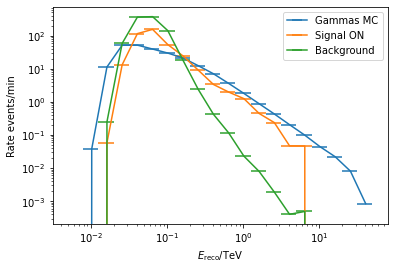

In [26]:
rate_gammas = signal_hist["n_weighted"]/T_OBS.to(u.min)
rate_on = on_hist["n_weighted"]/T_OBS.to(u.min)
area_ratio_p = (1-np.cos(theta_cuts_opt['cut']))/(1-np.cos(MAX_BG_RADIUS))
rate_background = background_hist["n_weighted"]*area_ratio_p/T_OBS.to(u.min)

plt.errorbar(
    0.5 * (signal_hist['reco_energy_low'] + signal_hist['reco_energy_high']).to_value(u.TeV),
    rate_gammas.to_value(1/u.min),
    xerr=0.5 * (signal_hist['reco_energy_high'] - signal_hist['reco_energy_low']).to_value(u.TeV),
    label='Gammas MC',
)
plt.errorbar(
    0.5 * (on_hist['reco_energy_low'] + on_hist['reco_energy_high']).to_value(u.TeV),
    rate_on.to_value(1/u.min),
    xerr=0.5 * (on_hist['reco_energy_high'] - on_hist['reco_energy_low']).to_value(u.TeV),
    label='Signal ON',
)
plt.errorbar(
    0.5 * (background_hist['reco_energy_low'] + background_hist['reco_energy_high']).to_value(u.TeV),
    rate_background.to_value(1/u.min),
    xerr=0.5 * (background_hist['reco_energy_high'] - background_hist['reco_energy_low']).to_value(u.TeV),
    label='Background',
)
plt.legend()
plt.ylabel('Rate events/min')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.yscale('log')
plt.show()

### PSF plot MC gammas

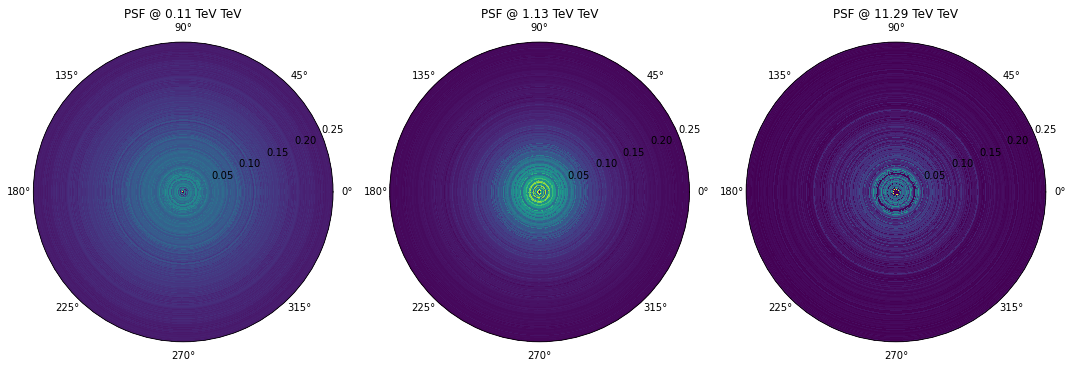

In [27]:
pyirf_file="pyirf_sensitivity.fits.gz"
psf_table = QTable.read(pyirf_file, hdu='PSF')[0]
# select the only fov offset bin
psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
phi_bins = np.linspace(0, 2 * np.pi, 100)

# Let's make a nice 2d representation of the radially symmetric PSF
r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

# look at a single energy bin
# repeat values for each phi bin
center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])

fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]

for bin_id, ax in zip([10, 20, 30], axs):
    image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))

    ax.set_title(f'PSF @ {center[bin_id]:.2f} TeV')
    ax.pcolormesh(phi, r, image)        
    ax.set_ylim(0, 0.25)
    ax.set_aspect(1)

fig.tight_layout()

plt.show()

### PSF plot with ON data

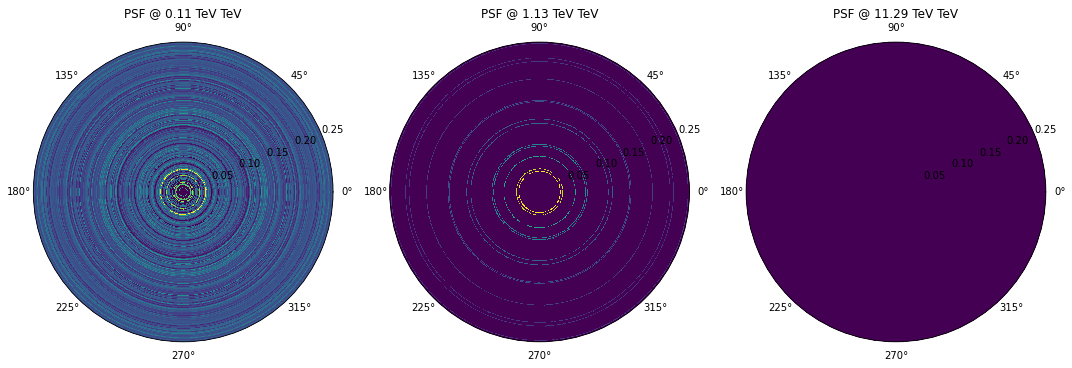

In [29]:
pyirf_file="pyirf_sensitivity.fits.gz"
psf_table = QTable.read(pyirf_file, hdu='PSF_ON')[0]
# select the only fov offset bin
psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
phi_bins = np.linspace(0, 2 * np.pi, 100)

# Let's make a nice 2d representation of the radially symmetric PSF
r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

# look at a single energy bin
# repeat values for each phi bin
center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])

fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]

for bin_id, ax in zip([10, 20, 30], axs):
    image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))

    ax.set_title(f'PSF @ {center[bin_id]:.2f} TeV')
    ax.pcolormesh(phi, r, image)        
    ax.set_ylim(0, 0.25)
    ax.set_aspect(1)

fig.tight_layout()

plt.show()

### Cuts

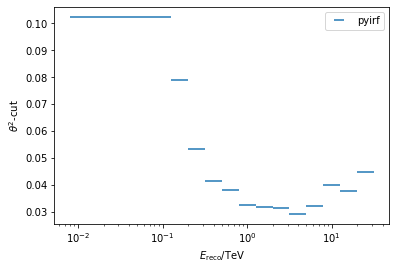

In [30]:
theta_cut = QTable.read(pyirf_file, hdu='THETA_CUTS_OPT')[1:-1]

plt.errorbar(
    0.5 * (theta_cut['low'] + theta_cut['high']).to_value(u.TeV),
    (theta_cut['cut']**2).to_value(u.deg**2),
    xerr=0.5 * (theta_cut['high'] - theta_cut['low']).to_value(u.TeV),
    ls='',
    label='pyirf',
    )

plt.legend()
plt.ylabel(r'$\theta^2$-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.show()

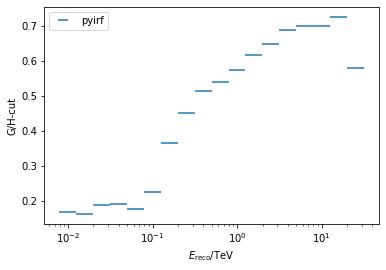

In [31]:
gh_cut = QTable.read(pyirf_file, hdu='GH_CUTS')[1:-1]

plt.errorbar(
    0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
    gh_cut['cut'],
    xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
    ls='',
    label='pyirf',
    )

plt.legend()
plt.ylabel('G/H-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.show()

### Collection Area (MC gammas)

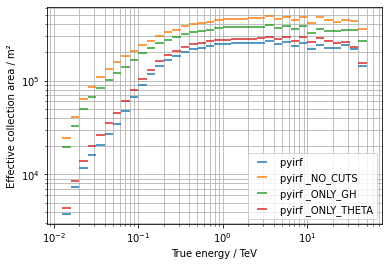

In [32]:
for name in ('', '_NO_CUTS', '_ONLY_GH', '_ONLY_THETA'):

    area = QTable.read(pyirf_file, hdu='EFFECTIVE_AREA' + name)[0]


    plt.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
        xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label='pyirf ' + name,
            )

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()
plt.show()

### Angular Resolution

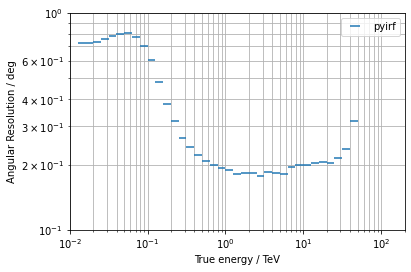

In [33]:
ang_res = QTable.read(pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]
plt.errorbar(
    0.5 * (ang_res['true_energy_low'] + ang_res['true_energy_high']).to_value(u.TeV),
    ang_res['angular_resolution'].to_value(u.deg),
    xerr=0.5 * (ang_res['true_energy_high'] - ang_res['true_energy_low']).to_value(u.TeV),
    ls='',
    label='pyirf'
    )

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(1.e-1, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Angular Resolution / deg")
plt.grid(which="both")
plt.legend(loc="best")
plt.show()

### Energy dispersion

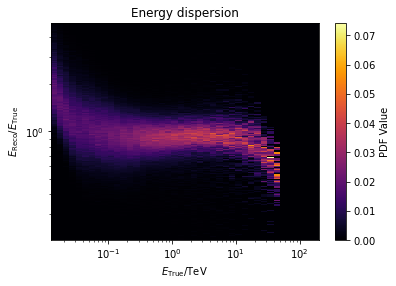

In [34]:
edisp = QTable.read(pyirf_file, hdu='ENERGY_DISPERSION')[0]

e_bins = edisp['ENERG_LO'][1:]
migra_bins = edisp['MIGRA_LO'][1:]

plt.title('Energy dispersion')
plt.pcolormesh(e_bins.to_value(u.TeV), migra_bins, edisp['MATRIX'].T[1:-1, 1:-1, 0].T, cmap='inferno')

plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='PDF Value')

plt.xlabel(r'$E_\mathrm{True} / \mathrm{TeV}$')
plt.ylabel(r'$E_\mathrm{Reco} / E_\mathrm{True}$')
plt.show()

### Energy resolution

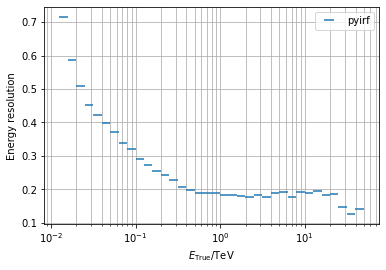

In [35]:
bias_resolution = QTable.read(pyirf_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]

# Plot function
plt.errorbar(
    0.5 * (bias_resolution['true_energy_low'] + bias_resolution['true_energy_high']).to_value(u.TeV),
    bias_resolution['resolution'],
    xerr=0.5 * (bias_resolution['true_energy_high'] - bias_resolution['true_energy_low']).to_value(u.TeV),
    ls='',
    label='pyirf'
    )
plt.xscale('log')

# Style settings
plt.xlabel(r"$E_\mathrm{True} / \mathrm{TeV}$")
plt.ylabel("Energy resolution")
plt.grid(which="both")
plt.legend(loc="best")
plt.show()